# 1. Thư viện và dữ liệu

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Scocial Media Data Mining/SourceCode/Thanh_Bert4News/UIT-VSMEC"

/content/drive/.shortcut-targets-by-id/1CZcWZiWtxpQUuZayUBOYLquIpN5fLP1b/Scocial Media Data Mining/SourceCode/Thanh_Bert4News/UIT-VSMEC


In [3]:
! pip install transformers 

     |████████████████████████████████| 2.5MB 7.8MB/s 
     |████████████████████████████████| 901kB 48.7MB/s 
     |████████████████████████████████| 3.3MB 50.4MB/s 


In [4]:
import torch
import pandas as pd
import numpy as np

# Thu vien transformer cho Classification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification, XLMRobertaForSequenceClassification, RobertaForSequenceClassification

# Xu ly label
from sklearn.preprocessing import LabelEncoder

# Metric danh gia 
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

# Ve do thi
import seaborn as sn
import matplotlib.pyplot as plt

In [5]:
# Xay dung data de fit vao mo hinh 
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [6]:
path = "/content/drive/MyDrive/Scocial Media Data Mining/Dataset"

In [7]:
train = pd.read_excel(path + "/UIT-VSMEC/train_nor_811.xlsx", index_col=False)
dev = pd.read_excel(path + "/UIT-VSMEC/valid_nor_811.xlsx", index_col=False)
test = pd.read_excel(path + "/UIT-VSMEC/test_nor_811.xlsx", index_col=False)

X_train = train['Sentence']
y_train = train['Emotion'].values

X_dev = dev['Sentence']
y_dev = dev['Emotion'].values

X_test = test['Sentence']
y_test = test['Emotion'].values

In [8]:
# encoding label 
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

#BERT4NEWS

In [9]:
num_labels = len(np.unique(y_test))

In [ ]:
path_model = ""

In [10]:
# Khai bao pre-trained
bert_model = BertForSequenceClassification.from_pretrained("NlpHUST/vibert4news-base-cased", num_labels = num_labels)
bert_tokenizer = BertTokenizer.from_pretrained("NlpHUST/vibert4news-base-cased")

Some weights of the model checkpoint at NlpHUST/vibert4news-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [12]:
train_encodings = bert_tokenizer(X_train.to_list(), truncation=True, padding=True, max_length=40)
dev_encodings = bert_tokenizer(X_dev.to_list(), truncation=True, padding=True, max_length=40)
test_encodings = bert_tokenizer(X_test.to_list(), truncation=True, padding=True, max_length=40)

y_train_encoding = le.transform(y_train)
y_dev_encoding = le.transform(y_dev)
y_test_encoding = le.transform(y_test)

import pickle

# saving
with open('/content/drive/MyDrive/Scocial Media Data Mining/SourceCode/Thanh_Bert4News/UIT-VSMEC/le.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Chuan bi data

train_dataset = BuildDataset(train_encodings, y_train_encoding)
dev_dataset = BuildDataset(dev_encodings, y_dev_encoding)
test_dataset = BuildDataset(test_encodings, y_test_encoding)

In [ ]:
# Chuan bi mo hinh

training_args = TrainingArguments(
    output_dir='./results_1',          
    num_train_epochs=100,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False
)

bert_trainer = Trainer(
    model=bert_model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

In [ ]:
# huan luyen mo hinh

bert_trainer.train()

Step,Training Loss
500,1.193700
1000,0.332200
1500,0.114300
2000,0.077900
2500,0.060900
3000,0.040000
3500,0.038500
4000,0.037700
4500,0.025400
5000,0.040400


TrainOutput(global_step=17400, training_loss=0.06305032277715275, metrics={'train_runtime': 4694.878, 'train_samples_per_second': 118.171, 'train_steps_per_second': 3.706, 'total_flos': 1.7797459425504e+16, 'train_loss': 0.06305032277715275, 'epoch': 100.0})

In [ ]:
# Du doan 
y_pred_classify = bert_trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)

In [ ]:
# Danh gia mo hinh
y_true = y_test_encoding

cf = confusion_matrix(y_true, y_pred)
print(cf)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

[[ 18  12   0   1   5   3   1]
 [ 10  81  13   4   9  11   4]
 [  0  12 137   1  18  22   3]
 [  0   3   2  35   1   5   0]
 [  4  24  20   0  58  19   4]
 [  3   8   9   3  11  81   1]
 [  1   2   8   0   6   3  17]]
F1 - micro: 0.6161616161616161
F1 - macro: 0.5971387767949762


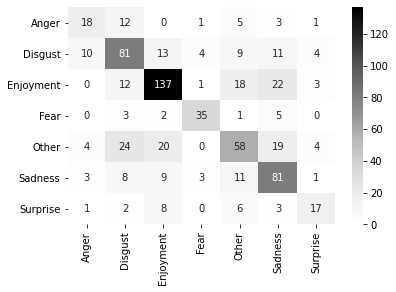

In [ ]:
# Ve ma tran nham lan
df_cm = pd.DataFrame(cf, index = np.unique(y_train),
                  columns = np.unique(y_train))

sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 10})

#Code đánh giá mô hình chi tiết trên 4 độ đo

In [ ]:
print(pd.Series(y_test).unique())
print(pd.Series(y_true).unique())

['Sadness' 'Surprise' 'Disgust' 'Fear' 'Anger' 'Other' 'Enjoyment']
[5 6 1 3 0 4 2]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# Danh gia mo hinh
y_true = y_test_encoding
y_pred_classify = bert_trainer.predict(test_dataset)
y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
cf = confusion_matrix(y_true, y_pred, labels= pd.Series(y_true).unique())

print(cf)
print("accuracy: " + str(accuracy_score(y_true, y_pred)))
print("F1 - macro: " + str(f1_score(y_true, y_pred, average='macro')))
target_names = pd.Series(y_test).unique()
print('Classification report in Training set')
print(classification_report(y_true, y_pred, labels=pd.Series(y_true).unique(), target_names=target_names))

[[ 81   1   8   3   3  11   9]
 [  3  17   2   0   1   6   8]
 [ 11   4  81   4  10   9  13]
 [  5   0   3  35   0   1   2]
 [  3   1  12   1  18   5   0]
 [ 19   4  24   0   4  58  20]
 [ 22   3  12   1   0  18 137]]
accuracy: 0.6161616161616161
F1 - macro: 0.5971387767949762
Classification report in Training set
              precision    recall  f1-score   support

     Sadness       0.56      0.70      0.62       116
    Surprise       0.57      0.46      0.51        37
     Disgust       0.57      0.61      0.59       132
        Fear       0.80      0.76      0.78        46
       Anger       0.50      0.45      0.47        40
       Other       0.54      0.45      0.49       129
   Enjoyment       0.72      0.71      0.72       193

    accuracy                           0.62       693
   macro avg       0.61      0.59      0.60       693
weighted avg       0.62      0.62      0.61       693



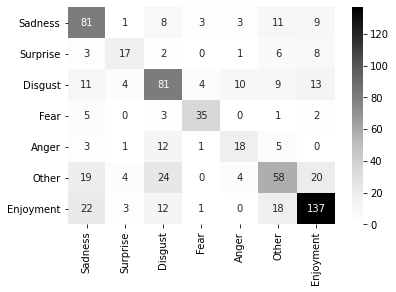

In [ ]:
# Ve ma tran nham lan
df_cm = pd.DataFrame(cf, index = pd.Series(y_test).unique(),
                  columns = pd.Series(y_test).unique())

sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 10})